In [1]:
#based on https://github.com/JuliaDynamics/CausalityTools.jl/blob/master/tutorials/Tutorial_BinnedResampling_RandomSequencesTest_PredictiveAsymmetryTest_ar1_unidir.ipynb
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames") 
Pkg.add("DynamicalSystems")
Pkg.add("CausalityTools")
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("LaTeXStrings")
Pkg.add("Interpolations")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Res

In [4]:
using CSV 
using DataFrames
using DynamicalSystems
using Statistics
using(LaTeXStrings)
using UncertainData, CausalityTools, Distributions, StatsBase, 
    Test, Interpolations, Plots

using DelimitedFiles


ArgumentError: [91mArgumentError: Package DynamicalSystemsBase not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("DynamicalSystemsBase")` to install the DynamicalSystemsBase package.[39m


In [11]:
#data = Dataset(rand(1000, 2))
#writedlm("Julia/test_data.txt", data, ',')
#data = Dataset(readdlm("data.txt", ',', Float64))

npts = 400

# Create `npts` time steps randomly distributed between 1 and 500,
# and add time uncertainties.
time = sort(rand(1:1000, npts))
ts = [UncertainValue(Normal(t, rand(Uniform(10, 20)))) for t in time]
    
# Generate some time series of length `npts` and add measurement uncertainties.
sys = CausalityTools.ar1_unidir(c_xy = 0.7)
xs, ys = columns(trajectory(sys, npts - 1))
x = UncertainIndexValueDataset(ts, [UncertainValue(Normal(x, rand())) for x in xs]) #rand() samples a random uniform in [0,1)
y = UncertainIndexValueDataset(ts, [UncertainValue(Normal(y, rand())) for y in ys])

# Draw 300000 independent samples in total (from time and values simultaneously)
# from the data. Based on the value of the time draws, distribute the value 
# draws in bins that are 20 time steps wide and covers the interval [0, 1000].
# For each bin, create a new value distribution that has no time uncertainty 
# (assuming equiprobable time within each bin) and a new uncertainty distribution
# in the values. The new distributions are KDE estimates to the distributions 
# in each bin, hence the large number of samples.
left_bin_edges = 0:10:1000
bin_instructions = BinnedResampling(left_bin_edges, 100000)
x_binned = resample(x, bin_instructions)
y_binned = resample(y, bin_instructions)

UncertainIndexValueDataset{UncertainIndexDataset,UncertainValueDataset} containing 100 uncertain values coupled with 100 uncertain indices


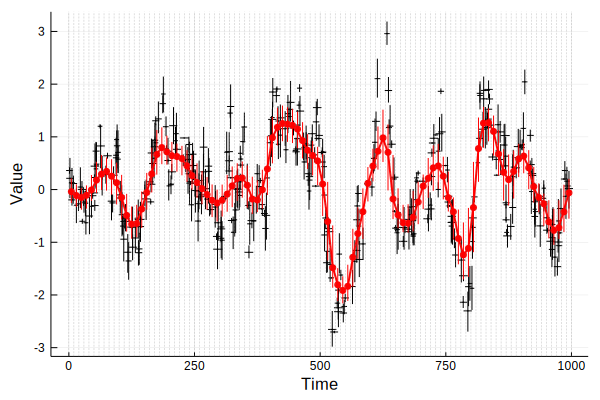

In [12]:

plot(xlabel = "Time", ylabel = "Value")
plot!(x, marker = stroke(0.01, :black), ms = 1, c = :black, label = "")
plot!(x_binned,  marker = stroke(0.01, :red), ms = 4, c = :red, label = "")
plot!(median.(x_binned.indices), median.(x_binned.values), lw = 2, c = :red, label = "")

vline!(left_bin_edges, c = :grey, lw = 0.5, lα = 0.5, ls = :dash, label = "")

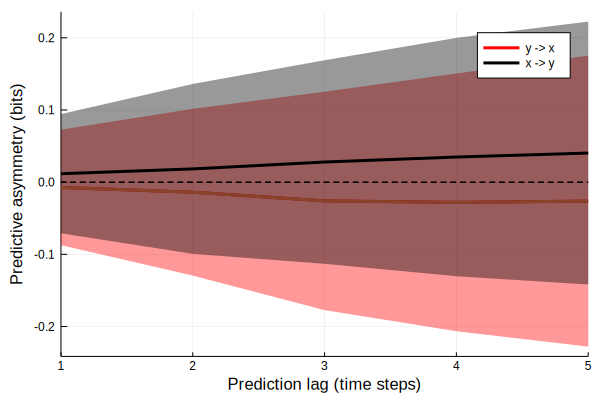

In [18]:
te_test = VisitationFrequencyTest(ηs = -5:5, binning = RectangularBinning(4))
pa_test = PredictiveAsymmetryTest(te_test)
# Run the causality test on 500 random subsampled chunks of lengths
# length(x_binned)-20 to length(x_binned)-1. Every time a chunk gets
# sampled, an independent realisation of the uncertain dataset is 
# drawn. Hence, to get 500 random realisations of the dataset within
# the uncertainties, we need to sample 500 different chunks (some 
# potentially identical, but on independent draws of the dataset).
L = length(x_binned)
ra_test = RandomSequencesTest(pa_test, RandomSequences(500, L-20:L-1))

# Compute predictive asymmetry in both directions.
pa_xy = causality(x_binned, y_binned, ra_test)
pa_yx = causality(y_binned, x_binned, ra_test);


xys = hcat(pa_xy...)
yxs = hcat(pa_yx...)

plot(xlabel = "Prediction lag (time steps)", ylabel = "Predictive asymmetry (bits)", xlims = (1, 5))
plot!(1:5, mean(yxs, dims=2), ribbon = std(yxs, dims = 2), lw = 3,
    label = "y -> x", fα = 0.4, c = :red)
plot!(1:5, mean(yxs, dims=2), lw = 3, label = "")
plot!(1:5, mean(xys, dims=2), ribbon = std(xys, dims = 2), lw = 3, 
    label = "x -> y", fα = 0.4, c = :black)
hline!([0], lw = 1.5, ls = :dash, c = :black, label = "")

